In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [90]:
args = {'lr':0.01,
        'train epochs':1200,
        'hidden layers':5,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0,
        'input features': 40,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'dropout':0.5
        }

now = datetime.now()

# Data Prep

In [91]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [92]:
df = pd.read_excel('data_3nm.xlsx')

In [93]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [94]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [95]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [96]:
# add noise
X_noisy = add_noise(X, args['noise'])

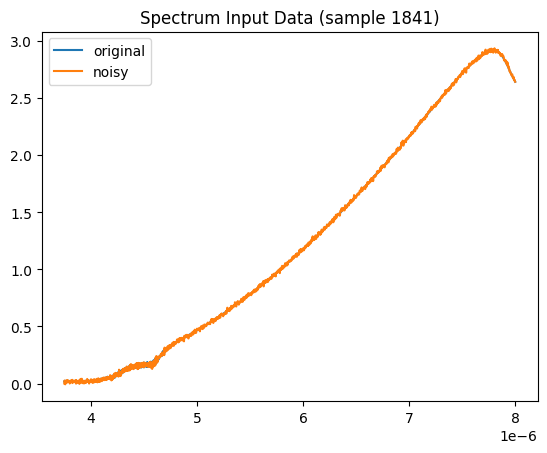

In [97]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [98]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [100]:
'''for layer in layers:
    inputs = X_train
    targets = y_train[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')

'''
# select features that correlate more than given amount
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')#'''


Features for Layer 1 (1417):
 [3.951e-06, 3.972e-06, 3.957e-06, 3.978e-06, 3.942e-06, 3.963e-06, 3.999e-06, 3.933e-06, 3.993e-06, 3.984e-06, 3.966e-06, 3.939e-06, 3.93e-06, 3.921e-06, 4.005e-06, 3.948e-06, 3.912e-06, 3.969e-06, 3.924e-06, 3.987e-06, 3.96e-06, 3.903e-06, 3.99e-06, 3.954e-06, 3.975e-06, 4.011e-06, 3.945e-06, 3.981e-06, 3.936e-06, 3.915e-06, 3.894e-06, 3.996e-06, 3.927e-06, 4.017e-06, 3.918e-06, 4.002e-06, 3.909e-06, 3.888e-06, 4.008e-06, 3.9e-06, 4.014e-06, 3.906e-06, 4.02e-06, 4.026e-06, 3.879e-06, 4.023e-06, 4.032e-06, 4.038e-06, 3.897e-06, 3.885e-06, 4.044e-06, 4.029e-06, 3.891e-06, 3.864e-06, 3.873e-06, 4.05e-06, 3.882e-06, 3.87e-06, 4.035e-06, 3.876e-06, 4.041e-06, 3.855e-06, 4.056e-06, 3.849e-06, 3.867e-06, 4.047e-06, 3.858e-06, 3.861e-06, 3.843e-06, 4.065e-06, 4.053e-06, 4.059e-06, 4.071e-06, 3.837e-06, 4.062e-06, 3.852e-06, 3.846e-06, 3.831e-06, 3.84e-06, 4.077e-06, 4.068e-06, 3.834e-06, 3.825e-06, 3.828e-06, 4.074e-06, 3.822e-06, 4.086e-06, 4.08e-06, 3.819e-06, 

In [101]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [102]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(args['dropout'])

    def forward(self, x):

        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.dropout(x)
        x = self.lin_fin(x)
        return x

In [103]:
criterion = args['train criterion']

In [104]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(input)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [1417, 1180, 944, 708, 472, 236]
epoch: 120, loss = 23.74762535095215
epoch: 240, loss = 12.949700355529785
epoch: 360, loss = 9.367058753967285
epoch: 480, loss = 7.827273845672607
epoch: 600, loss = 6.764279365539551
epoch: 720, loss = 6.012024402618408
epoch: 840, loss = 5.061046123504639
epoch: 960, loss = 4.532175064086914
epoch: 1080, loss = 4.325577259063721
epoch: 1200, loss = 4.0151777267456055
best loss: 4.00610876083374 in epoch 1138

layer 2
hidden layer sizes: [1417, 1180, 944, 708, 472, 236]
epoch: 120, loss = 21.08757781982422
epoch: 240, loss = 11.609037399291992
epoch: 360, loss = 9.629240036010742
epoch: 480, loss = 8.15575885772705
epoch: 600, loss = 6.524449348449707
epoch: 720, loss = 5.855319499969482
epoch: 840, loss = 5.649372100830078
epoch: 960, loss = 4.99685525894165
epoch: 1080, loss = 4.865335941314697
epoch: 1200, loss = 4.49058198928833
best loss: 4.467218399047852 in epoch 1197

layer 3
hidden layer sizes: [1417, 1180, 944, 7

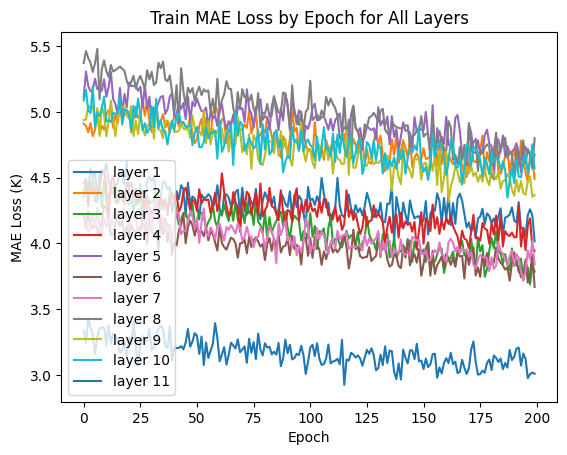

In [105]:
for layer in layers:
    plt.plot(layer['train losses'][-200:], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [106]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

        layer['test pred'] = pred

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(test_losses)/len(test_losses)}")

layer 1 loss: 5.542391777038574
layer 2 loss: 10.562891006469727
layer 3 loss: 5.825879096984863
layer 4 loss: 5.6426615715026855
layer 5 loss: 6.249382972717285
layer 6 loss: 5.857687950134277
layer 7 loss: 6.595005989074707
layer 8 loss: 5.445986747741699
layer 9 loss: 5.444251537322998
layer 10 loss: 4.771605014801025
layer 11 loss: 3.2737009525299072
Average: 5.9283131469379775


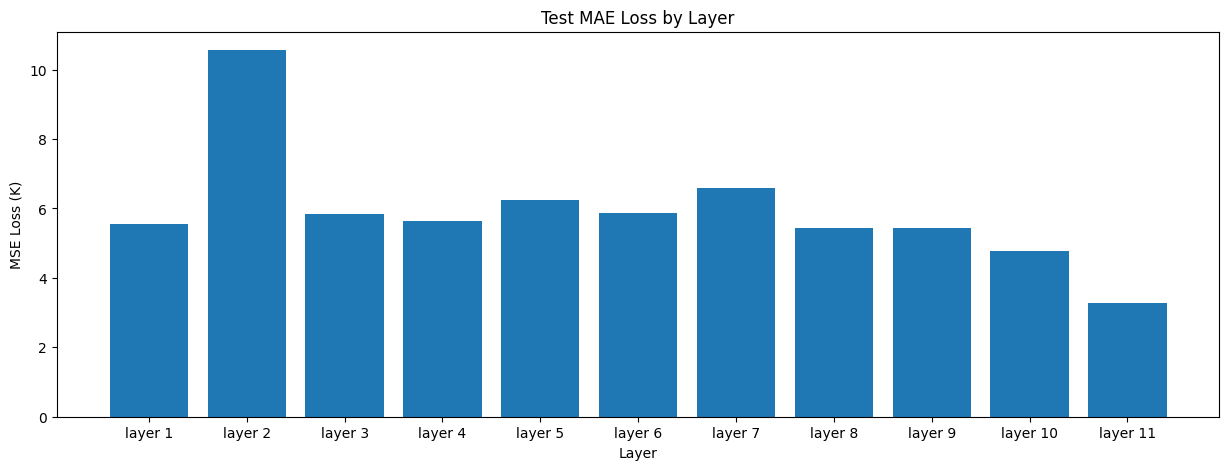

In [107]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [108]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [109]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

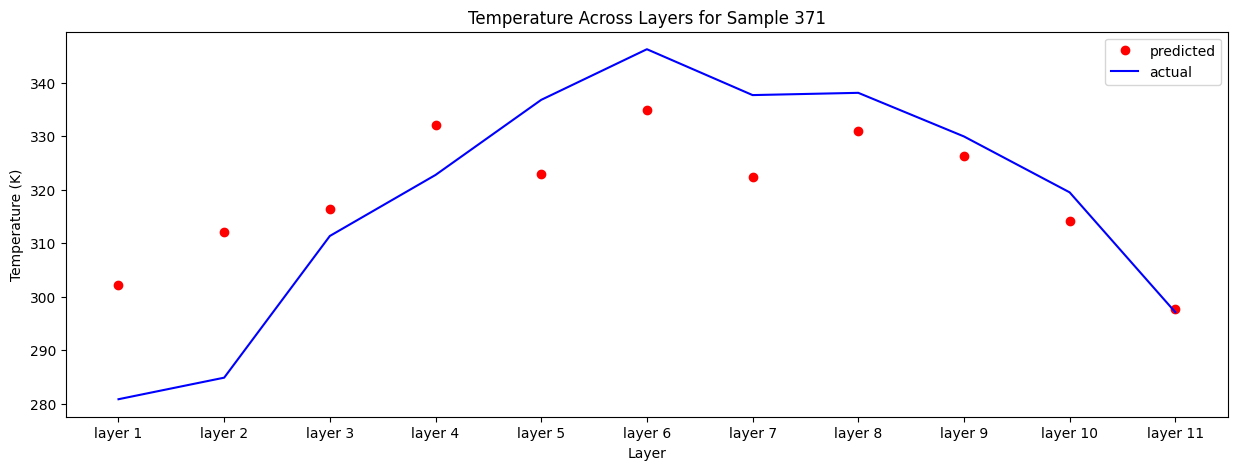

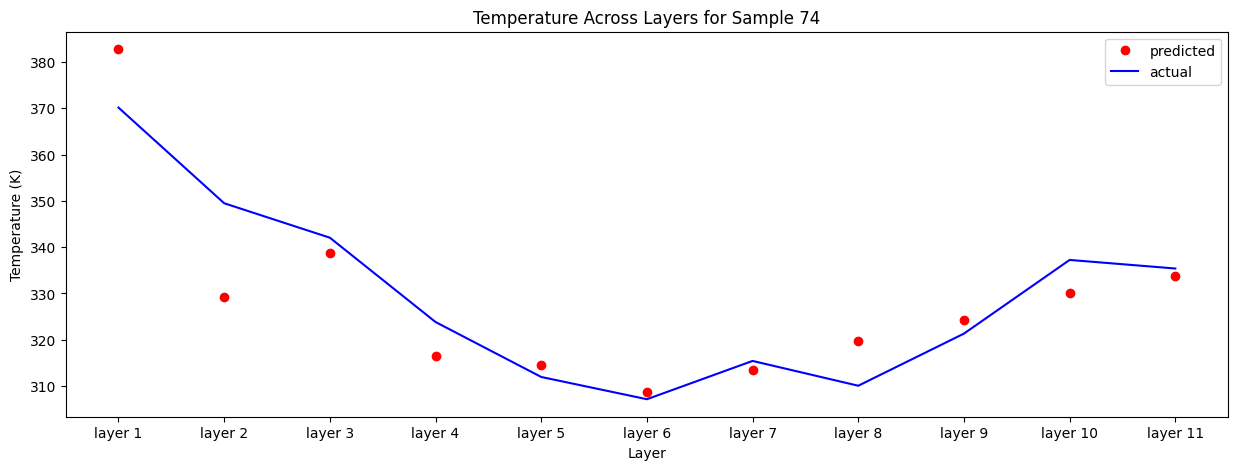

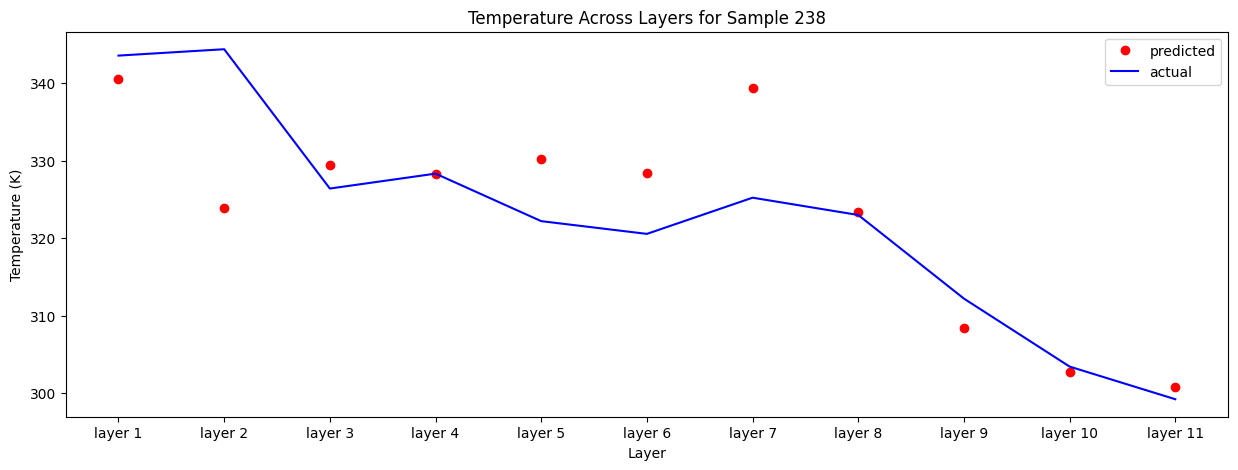

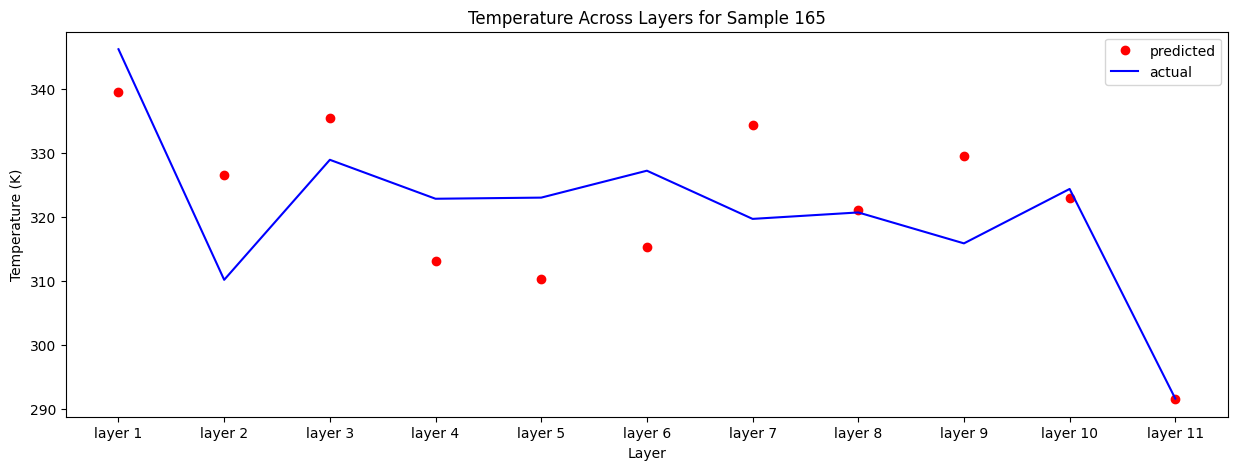

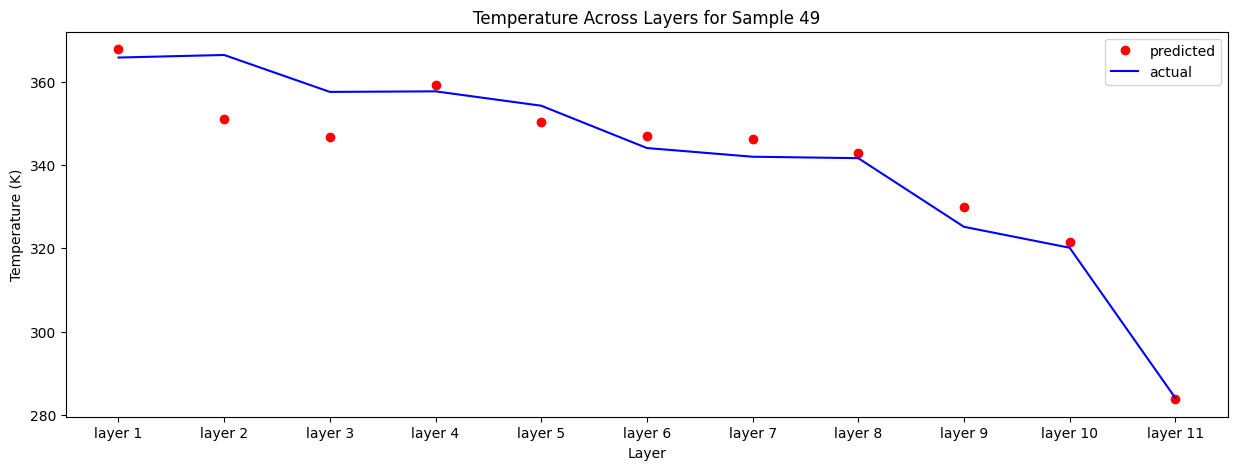

In [110]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [111]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')

In [112]:
model = layers[0]['model']
x = layers[0]['X_test']
y = model(x)